In [2]:
import pandas as pd
import numpy as np
import math
# import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [3]:
input_filename = "final_analysis_20210307_132723.csv"
cols = pd.read_csv(input_filename, nrows=1).columns
df = pd.read_csv(input_filename, usecols=cols[1:])
df = df.loc[df['pctavail'] == 1]

In [4]:
# Split into training, CV, and test
# Note: check that the proportion of *observations* assigned matches what you want. If not, change the random seed
stocks = pd.DataFrame(df['symbol'].unique())
stocks.rename({0:'symbol'}, axis='columns', inplace=True)
nStocks = len(stocks)

# Set % of stocks in training and CV sets
pctTraining = 0.6
pctCV = 0.2
seedVal = 260000

np.random.seed(seedVal)
stocks['rand'] = np.random.rand(nStocks)
conditions = [(stocks['rand'] <= pctTraining), (stocks['rand'] > pctTraining) & (stocks['rand'] <= (pctTraining + pctCV)),(stocks['rand'] > (pctTraining + pctCV))]
stocks['bucket'] = np.select(conditions,['training','cv','test'])

assdf = pd.merge(df,stocks,left_on='symbol',right_on='symbol')

print("% Train: " + str(sum(assdf['bucket'] == 'training') / len(assdf)))
print("% CV:    " + str(sum(assdf['bucket'] == 'cv') / len(assdf)))
print("% Test:  " + str(sum(assdf['bucket'] == 'test') / len(assdf)))

% Train: 0.6059597214732844
% CV:    0.19993904297470283
% Test:  0.19410123555201275


In [5]:
# Dataset stats
print(len(df))
print(len(stocks))

42653
142


In [6]:
# Create X and Y arrays for the logistic regression
# Set helpful variables
xdf = assdf[assdf['bucket'] == 'training']
xCVdf = assdf[assdf['bucket'] == 'cv']
xTestdf = assdf[assdf['bucket'] == 'test']

m = len(xdf)
n = 61
print(m,n)

xColNames = []
for n in range(1,n+1):
    xColNames.append("avgp_minus" + str(n))
    
x = xdf[xColNames].to_numpy()
xCV = xCVdf[xColNames].to_numpy()
xTest = xTestdf[xColNames].to_numpy()

y = xdf['closedUp'].to_numpy()
yCV = xCVdf['closedUp'].to_numpy()
yTest = xTestdf['closedUp'].to_numpy()

25846 61


In [11]:
model = LogisticRegression(solver='liblinear', C=1, random_state=0)
model.fit(x,y)

LogisticRegression(C=1, random_state=0, solver='liblinear')

In [12]:
# model.classes_
# model.predict_proba(x)
model.predict(x)

array([1, 0, 1, ..., 0, 1, 1])

In [13]:
#accuracy on training set
model.score(xCV,yCV)

0.5375234521575984

In [ ]:
confusion_matrix(y, model.predict(x))

In [14]:
# Run the logistic regression, choosing the best regularization hyperparameter
# Reference: https://realpython.com/logistic-regression-python/

lSet = [.001, .1, .3, 1, 3, 10, 30, 100]
bestAcc = 0
bestLambda = -1
for l in lSet:
    m = LogisticRegression(solver='liblinear', C=l, random_state=0)
    m.fit(x,y)
    cvScore = m.score(xCV,yCV)
    print(l, cvScore)
    if cvScore > bestAcc:
        bestAcc = cvScore
        bestLambda = l
print("---\nBest l: " + str(bestLambda) + " Acc: " + str(bestAcc))

0.001 0.5069183864915572
0.1 0.5181754221388368
0.3 0.5236866791744841
1 0.5375234521575984
3 0.5521810506566605
10 0.5580440900562852
30 0.5560506566604128
100 0.5548780487804879
---
Best l: 10 Acc: 0.5580440900562852


In [15]:
mFinal = LogisticRegression(solver='liblinear', C=bestLambda, random_state=0)
mFinal.fit(x,y)
cvScore = mFinal.score(xTest,yTest)
print("Accuracy: " + str(cvScore) + " with lambda: " + str(bestLambda))

Accuracy: 0.5701171639086846 with lambda: 10


              precision    recall  f1-score   support

           0       0.58      0.46      0.52      4082
           1       0.56      0.67      0.61      4197

    accuracy                           0.57      8279
   macro avg       0.57      0.57      0.56      8279
weighted avg       0.57      0.57      0.57      8279



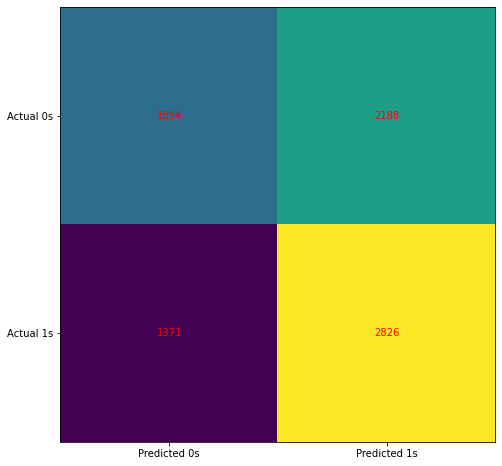

In [69]:
print(classification_report(yTest,mFinal.predict(xTest)), sep='\n')

cm = confusion_matrix(yTest,mFinal.predict(xTest))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
# SVM portion:

# x = xdf[xColNames].to_numpy()
# xCV = xCVdf[xColNames].to_numpy()
# xTest = xTestdf[xColNames].to_numpy()

# y = xdf['closedUp'].to_numpy()
# yCV = xCVdf['closedUp'].to_numpy()
# yTest = xTestdf['closedUp'].to_numpy()

In [ ]:
#compare kernels: linear vs Gaussian

In [18]:
print(datetime.now().time())
scm_lin = svm.SVC(kernel='linear')

23:51:50.788298


In [19]:
print(datetime.now().time())
scm_lin.fit(x,y)

23:51:55.109213


SVC(kernel='linear')

In [20]:
print(datetime.now().time())
scm_lin.score(xCV,yCV)

23:53:45.370480


0.512546904315197

In [21]:
print(datetime.now().time())
scm_gau = svm.SVC(kernel='rbf')

23:54:02.187694


In [22]:
print(datetime.now().time())
scm_gau.fit(x,y)

23:54:02.199140


SVC()

In [23]:
print(datetime.now().time())
scm_gau.score(xCV,yCV)

23:55:50.702745


0.5695356472795498

In [65]:
# evaluate optimal value of hyperparameters C and sigma
c_tries = [0.01,0.1,1,10,100]
s_tries = [0.01,0.1,1,10,100]

gauss_results = pd.DataFrame(columns =['c','s','score'])
n_run = 1
max_runs = len(c_tries) * len(s_tries)
for c in c_tries:
    for s in s_tries:
        print("-----\nRunning " + str(n_run) + "/" + str(max_runs) + " with c=" + str(c) + " s=" + str(s))
        this_svm = svm.SVC(C=c, kernel='rbf', gamma=s)
        this_svm.fit(x,y)
        this_score = this_svm.score(xCV,yCV)
        if n_run == 1:
            best_svm = this_svm
            best_score = this_score
        if this_score > gauss_results['score'].max():
            best_svm = this_svm
            best_score = this_score
        gauss_results = gauss_results.append({'c' : c, 's' : s, 'score': this_score}, ignore_index=True)
        print("Score: " + str(this_score))
        print("Done: " + str(datetime.now().time()))
        n_run = n_run + 1
    
gauss_results.to_csv(os.getcwd() + '/outputs/svm_gauss_results_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')
print(best_score)
print(gauss_results)

-----
Running 1/25 with c=0.01 s=0.01
Score: 0.5066838649155723
Done: 03:16:59.556187
-----
Running 2/25 with c=0.01 s=0.1
Score: 0.5066838649155723
Done: 03:19:25.868393
-----
Running 3/25 with c=0.01 s=1
Score: 0.5066838649155723
Done: 03:21:54.285392
-----
Running 4/25 with c=0.01 s=10
Score: 0.5066838649155723
Done: 03:24:32.304178
-----
Running 5/25 with c=0.01 s=100
Score: 0.5066838649155723
Done: 03:27:13.193136
-----
Running 6/25 with c=0.1 s=0.01
Score: 0.5066838649155723
Done: 03:29:42.385323
-----
Running 7/25 with c=0.1 s=0.1
Score: 0.5066838649155723
Done: 03:32:12.436152
-----
Running 8/25 with c=0.1 s=1
Score: 0.5066838649155723
Done: 03:34:39.104375
-----
Running 9/25 with c=0.1 s=10
Score: 0.5313086303939962
Done: 03:37:15.549781
-----
Running 10/25 with c=0.1 s=100
Score: 0.5184099437148217
Done: 03:39:55.883900
-----
Running 11/25 with c=1 s=0.01
Score: 0.5066838649155723
Done: 03:42:27.045864
-----
Running 12/25 with c=1 s=0.1
Score: 0.5075046904315197
Done: 03:44:5

In [67]:
# do learning curves to check whether 
# use the best c and sigma vlue from the block above
c = gauss_results.iloc[gauss_results['score'].idxmax()]['c']
sigma = gauss_results.iloc[gauss_results['score'].idxmax()]['s']
print("Using c = " + str(c) + " sigma = " + str(sigma))


# mvals = [50,100,200,500]
mvals = [1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000, 25000]

lc_data = pd.DataFrame(columns =['m','accTrain','accCV'])
for m in mvals:
    print("-----\nRunning with m=" + str(m))
    xsubset = x[:m,:]
    ysubset = y[:m]
    this_svm = svm.SVC(C=c, kernel='rbf', gamma=sigma)
    this_svm.fit(xsubset,ysubset)
    this_score_test = this_svm.score(xsubset,ysubset)
    this_score_cv = this_svm.score(xCV,yCV)
    lc_data = lc_data.append({'m' : m, 'accTrain' : this_score_test, 'accCV': this_score_cv}, ignore_index=True)
    print("CV score: " + str(this_score_cv))
    print("Done: " + str(datetime.now().time()))
  
print("\n")
lc_data.to_csv(os.getcwd() + '/outputs/svm_gauss_learncurves_' + datetime.now().strftime("%Y%m%d_%H%M%S") + '.csv')
print(lc_data)

Using c = 10.0 sigma = 10.0
-----
Running with m=1000
CV score: 0.5159474671669794
Done: 06:41:50.307141
-----
Running with m=2000
CV score: 0.5370544090056285
Done: 06:41:54.115912
-----
Running with m=3000
CV score: 0.5443245778611632
Done: 06:42:00.510192
-----
Running with m=4000
CV score: 0.5471388367729831
Done: 06:42:10.243332
-----
Running with m=5000
CV score: 0.5519465290806754
Done: 06:42:23.920359
-----
Running with m=7500
CV score: 0.5569887429643527
Done: 06:42:51.061903
-----
Running with m=10000
CV score: 0.5556988742964353
Done: 06:43:39.022816
-----
Running with m=15000
CV score: 0.5771575984990619
Done: 06:45:19.720138
-----
Running with m=20000
CV score: 0.5825515947467167
Done: 06:48:18.309914
-----
Running with m=25000
CV score: 0.5823170731707317
Done: 06:53:07.569992


         m  accTrain     accCV
0   1000.0  0.786000  0.515947
1   2000.0  0.775500  0.537054
2   3000.0  0.761667  0.544325
3   4000.0  0.753750  0.547139
4   5000.0  0.747200  0.551947
5   7500.0

In [68]:
final_score = best_svm.score(xTest,yTest)
print(final_score)


0.5970527841526755


              precision    recall  f1-score   support

           0       0.61      0.52      0.56      4082
           1       0.59      0.67      0.63      4197

    accuracy                           0.60      8279
   macro avg       0.60      0.60      0.59      8279
weighted avg       0.60      0.60      0.59      8279



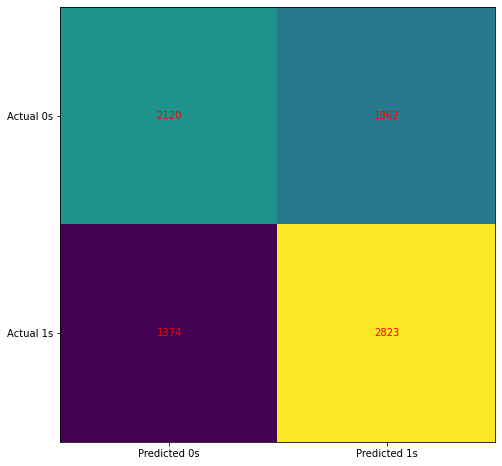

In [70]:
print(classification_report(yTest,best_svm.predict(xTest)), sep='\n')

cm = confusion_matrix(yTest,best_svm.predict(xTest))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()